### Section 2: Multi Armed Bandits

#### 7.0 Thompson Sampling with Gaussian Reward Theory

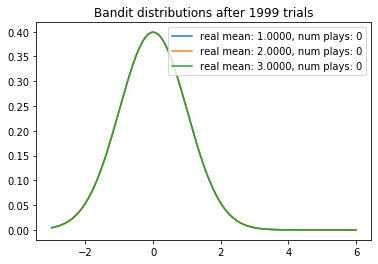

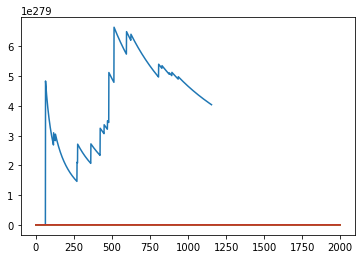

In [27]:
from __future__ import print_function, division
from builtins import range

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


np.random.seed(1)
NUM_TRIALS = 2000
BANDIT_MEANS = [1, 2, 3]


class Bandit:
    def __init__(self, true_mean):
        # The problem we have set ourselves is one where the Bandits have unknown mean, but known precision hence
        # only one input argument, the true_mean. We assume the precision of the rewards is 1 (same as variance =1)
        self.true_mean = true_mean
        # Precision of rewards (assumed = 1)
        self.tau = 1
            
        # parameters for mu (the mean of X) are (m,lambda), initialised to 0,1 hence prior is N(0,1)
        # Predicted mean, m, (this is the mean of the mean of X, the probability of win). We initialise this to 0.
        self.m = 0
        # This is the precision of the mean of X, the probability of a win). Lambda initialised to 1. 
        self.lambda_ = 1
        
        self.sum_x = 0 # stores the sample of all the samples we collect, for convenience
        # Number of times we play this bandit
        self.N = 0
  
    def pull(self):
        # Draws a random sample from the normal distribution with mean=true_mean and precision=tau
        # Note this is the bandit reward amount (before it was simply 1,0 or True/False. Now it varies with a distribution.)
        return np.random.randn() / np.sqrt(self.tau) + self.true_mean
  
    def sample(self):
        # Probability of a win from bandit is also a guassian, but with mean, precision of m and lambda resepctively 
        return np.random.randn() / np.sqrt(self.lambda_) + self.m
  
    def update(self, x):
        # Formula is lambda = tau*N + lambda_0, but N=1
        self.lambda_ += self.tau
        # Increase the total reward amount, x
        self.sum_x += x
        # Posterior Mean, m = tau/lambda * sum(xi + lambda_0*m0), but we assume the mean of prior = 0
        self.m = self.tau*self.sum_x / self.lambda_
        # Number of times we've played this bandit
        self.N += 1


def plot(bandits, trial):
    x = np.linspace(-3, 6, 200)
    for b in bandits:
        y = norm.pdf(x, b.m, np.sqrt(1. / b.lambda_))
        plt.plot(x, y, label=f"real mean: {b.true_mean:.4f}, num plays: {b.N}")
    plt.title(f"Bandit distributions after {trial} trials")
    plt.legend()
    plt.show()


def run_experiment():
    bandits = [Bandit(m) for m in BANDIT_MEANS]

    sample_points = [5,10,20,50,100,200,500,1000,1500,1999]
    rewards = np.empty(NUM_TRIALS)
    for i in range(NUM_TRIALS):
        # Thompson sampling
        j = np.argmax([b.sample() for b in bandits])
  
      # plot the posteriors
    if i in sample_points:    
        plot(bandits, i)
  
    # pull the arm for the bandit with the largest sample
    x = bandits[j].pull()

    # update the distribution for the bandit whose arm we just pulled
    bandits[j].update(x)

    # update rewards
    rewards[i] = x
  
    cumulative_average = np.cumsum(rewards) / (np.arange(NUM_TRIALS) + 1)
  
    # plot moving average ctr
    plt.plot(cumulative_average)
    for m in BANDIT_MEANS:
        plt.plot(np.ones(NUM_TRIALS)*m)
    plt.show()
  
    return cumulative_average

if __name__ == '__main__':
    run_experiment()


#### 6.0 Thompson Sampling

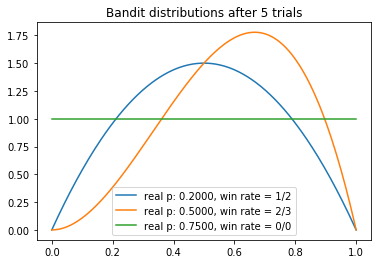

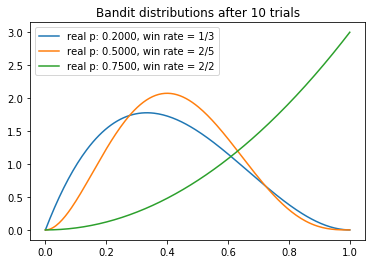

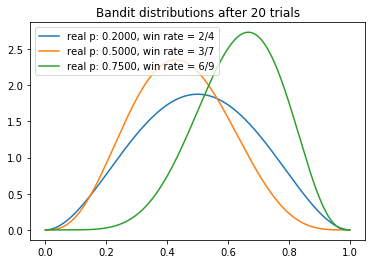

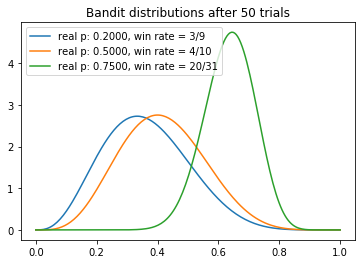

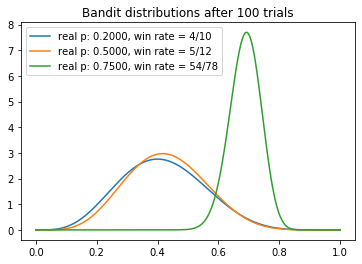

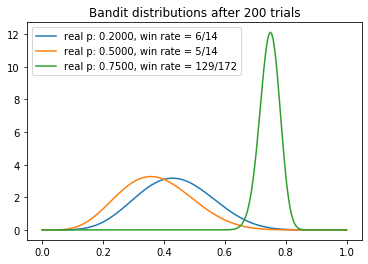

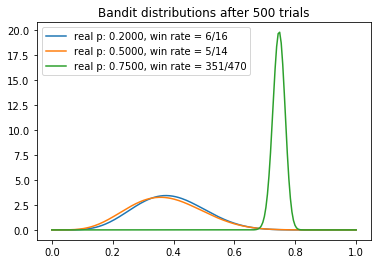

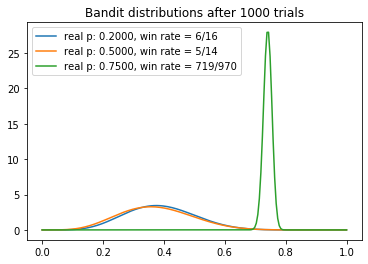

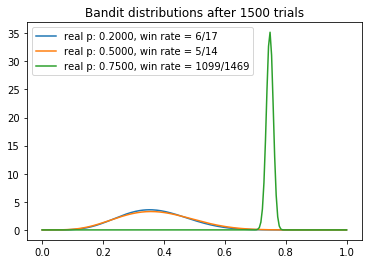

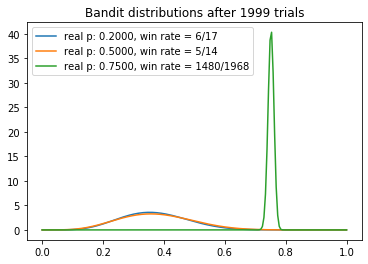

total reward earned: 1492.0
overall win rate: 0.746
num times selected each bandit: [17, 14, 1969]


In [25]:
from __future__ import print_function, division
from builtins import range

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta


# np.random.seed(2)
NUM_TRIALS = 2000
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]


class Bandit:
    def __init__(self, p):
        self.p = p
        self.a = 1 # TODO
        self.b = 1 # TODO
        self.N = 0 # for information only
  
    def pull(self):
        return np.random.random() < self.p
  
    def sample(self):
        # Draw random sample from the beta distribution
        return np.random.beta(self.a, self.b) # TODO - draw a sample from Beta(a, b)
  
    def update(self, x):
        # posterior becomes the prior on each iteration - hence a, b get overwritten
        self.a += x # TODO
        self.b += 1 - x # TODO
        self.N += 1


def plot(bandits, trial):
    # Create linspace array
    x = np.linspace(0, 1, 200)
    # Loop over bandits
    for b in bandits:
        # Get array, y, for beta probability distribution function
        y = beta.pdf(x, b.a, b.b)
        # Note the win_rate = (alpha-1)/N (because a = sum of rewards, x=1)
        plt.plot(x, y, label=f"real p: {b.p:.4f}, win rate = {b.a - 1}/{b.N}")
    plt.title(f"Bandit distributions after {trial} trials")
    plt.legend()
    plt.show()


def experiment():
    bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]
  
    # Set the number of trials at which you want to plot the posterior distributions
    sample_points = [5,10,20,50,100,200,500,1000,1500,1999]
    rewards = np.zeros(NUM_TRIALS)
    for i in range(NUM_TRIALS):
        # Thompson sampling
        j = np.argmax([b.sample() for b in bandits]) # TODO
        
        # plot the posteriors
        if i in sample_points:
            plot(bandits, i)
    
        # pull the arm for the bandit with the largest sample
        x = bandits[j].pull()
    
        # update rewards
        rewards[i] = x
    
        # update the distribution for the bandit whose arm we just pulled
        bandits[j].update(x)
  
    # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / NUM_TRIALS)
    print("num times selected each bandit:", [b.N for b in bandits])


if __name__ == "__main__":
    experiment()

#### 5.0 - UCB1 Theory

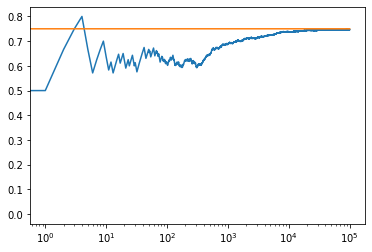

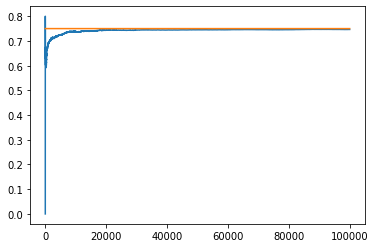

0.20270270270270271
0.5135135135135125
0.7478781426089092
total reward earned: 74661.0
overall win rate: 0.74661
num times selected each bandit: [74.0, 370.0, 99559.0]


In [42]:
from __future__ import print_function, division
from builtins import range
import numpy as np
import matplotlib.pyplot as plt


NUM_TRIALS = 100000
EPS = 0.1
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]


class Bandit:
    def __init__(self, p):
        # p: the win rate
        self.p = p
        self.p_estimate = 0.
        self.N = 0. # num samples collected so far
  
    def pull(self):
        # draw a 1 with probability p
        return np.random.random() < self.p
  
    def update(self, x):
        self.N += 1.
        self.p_estimate = ((self.N - 1)*self.p_estimate + x) / self.N


def ucb(mean, n, nj):
    # Return the value that we want to be greedy with respect to
    return mean + np.sqrt(2*np.log(n)/nj) # TODO


def run_experiment():
    bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]
    rewards = np.empty(NUM_TRIALS)
    total_plays = 0
  
    # initialization: play each bandit once
    for j in range(len(bandits)):
        x = bandits[j].pull()
        total_plays += 1
        bandits[j].update(x)
    
    for i in range(NUM_TRIALS):
        j = np.argmax([ucb(b.p_estimate, total_plays, b.N) for b in bandits]) # TODO
        x = bandits[j].pull()
        total_plays += 1
        bandits[j].update(x)
    
        # for the plot
        rewards[i] = x
    cumulative_average = np.cumsum(rewards) / (np.arange(NUM_TRIALS) + 1)
  
    # plot moving average ctr
    plt.plot(cumulative_average)
    plt.plot(np.ones(NUM_TRIALS)*np.max(BANDIT_PROBABILITIES))
    plt.xscale('log')
    plt.show()
  
    # plot moving average ctr linear
    plt.plot(cumulative_average)
    plt.plot(np.ones(NUM_TRIALS)*np.max(BANDIT_PROBABILITIES))
    plt.show()
  
    for b in bandits:
        print(b.p_estimate)
  
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / NUM_TRIALS)
    print("num times selected each bandit:", [b.N for b in bandits])
  
    return cumulative_average

if __name__ == '__main__':
    run_experiment()


#### 4.0 - optimistic initial value

mean estimate: 0.7000000000000002
mean estimate: 0.7000000000000001
mean estimate: 0.7540901334939265
total reward earned: 7526.0
overall win rate: 0.7526
num times selected each bandit: [10, 30, 9963]


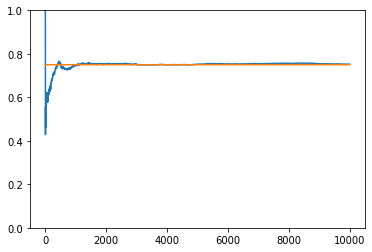

In [40]:
from __future__ import print_function, division
from builtins import range
import matplotlib.pyplot as plt
import numpy as np


NUM_TRIALS = 10000
EPS = 0.1
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]


class Bandit:
    def __init__(self, p):
        # p: the win rate
        self.p = p
        self.p_estimate = 5# TODO
        self.N = 1 # TODO

    def pull(self):
        # draw a 1 with probability p
        return np.random.random() < self.p

    def update(self, x):
        # TODO
        self.N += 1
        self.p_estimate = (1 - 1.0/self.N)*self.p_estimate + 1.0/self.N*x # TODO

def experiment():
    bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]

    rewards = np.zeros(NUM_TRIALS)
    for i in range(NUM_TRIALS):
      # use optimistic initial values to select the next bandit
      j = np.argmax([b.p_estimate for b in bandits]) # TODO

      # pull the arm for the bandit with the largest sample
      x = bandits[j].pull()

      # update rewards log
      rewards[i] = x

      # update the distribution for the bandit whose arm we just pulled
      bandits[j].update(x)


    # print mean estimates for each bandit
    for b in bandits:
        print("mean estimate:", b.p_estimate)
  
    # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / NUM_TRIALS)
    print("num times selected each bandit:", [b.N for b in bandits])
  
    # plot the results
    cumulative_rewards = np.cumsum(rewards)
    win_rates = cumulative_rewards / (np.arange(NUM_TRIALS) + 1)
    plt.ylim([0, 1])
    plt.plot(win_rates)
    plt.plot(np.ones(NUM_TRIALS)*np.max(BANDIT_PROBABILITIES))
    plt.show()

if __name__ == "__main__":
    experiment()

#### 3.0 comparing epsilons

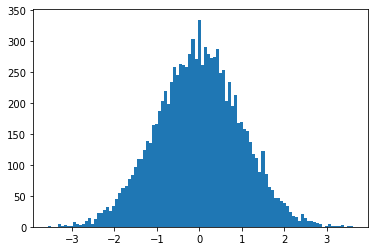

In [4]:
# Show random distribution
import numpy as np
import matplotlib.pyplot as plt 
i = []
for j in range(0,10000):
    i.append(np.random.randn())
i.sort()
plt.hist(i, bins=100);

#### 2.0 (see .py file)

#### 1.0 greedy and epsilon greedy (wrong)

In [1]:
import random

# Define probabilistic game outcome
def win_lose(a, b):
    x = random.randint(a,b)
    if x > 50:
        y = 1
    else:
        y = 0
    return y

def play_A():
    print("playing A")
    y = win_lose(1,100)
    print("y: ", y)
    return y

def play_B():
    print("playing B")
    y = win_lose(1,60)
    print("y: ", y)
    return y

In [2]:
# Greedy
A_wins = A_plays = B_plays = B_wins = 0
A_win_rate = B_win_rate = 0.1
epochs = 100

for i in range(0,epochs):    
    print("i:", i)
    if (A_win_rate == 0) & (B_win_rate == 0):
        y = play_A()
        A_plays += 1
        A_wins += y
        A_win_rate = A_wins/A_plays
    elif A_win_rate >= B_win_rate:
        y = play_A()
        A_plays += 1
        A_wins += y
        A_win_rate = A_wins/A_plays
    else:
        y = play_B()
        B_plays += 1
        B_wins += y
        B_win_rate = B_wins/B_plays
    print("A_win_rate: ", A_win_rate)
    print("B_win_rate: ", B_win_rate)
    print("A_plays: ", A_plays)
    print("B_plays: ", B_plays)
    print("\n")

i: 0
playing A
y:  1
A_win_rate:  1.0
B_win_rate:  0.1
A_plays:  1
B_plays:  0


i: 1
playing A
y:  0
A_win_rate:  0.5
B_win_rate:  0.1
A_plays:  2
B_plays:  0


i: 2
playing A
y:  1
A_win_rate:  0.6666666666666666
B_win_rate:  0.1
A_plays:  3
B_plays:  0


i: 3
playing A
y:  0
A_win_rate:  0.5
B_win_rate:  0.1
A_plays:  4
B_plays:  0


i: 4
playing A
y:  1
A_win_rate:  0.6
B_win_rate:  0.1
A_plays:  5
B_plays:  0


i: 5
playing A
y:  1
A_win_rate:  0.6666666666666666
B_win_rate:  0.1
A_plays:  6
B_plays:  0


i: 6
playing A
y:  1
A_win_rate:  0.7142857142857143
B_win_rate:  0.1
A_plays:  7
B_plays:  0


i: 7
playing A
y:  1
A_win_rate:  0.75
B_win_rate:  0.1
A_plays:  8
B_plays:  0


i: 8
playing A
y:  0
A_win_rate:  0.6666666666666666
B_win_rate:  0.1
A_plays:  9
B_plays:  0


i: 9
playing A
y:  1
A_win_rate:  0.7
B_win_rate:  0.1
A_plays:  10
B_plays:  0


i: 10
playing A
y:  0
A_win_rate:  0.6363636363636364
B_win_rate:  0.1
A_plays:  11
B_plays:  0


i: 11
playing A
y:  1
A_win_ra

In [3]:
# Epsilon Greedy
A_wins = A_plays = B_plays = B_wins = 0
A_win_rate = B_win_rate = 0.1
epochs = 100
epsilon = 0.1
            
for i in range(0,epochs):
    print("i:", i)
    # Choose whether to choose a random bandit
    p = random.randint(0,100)/100
    if p < epsilon:
        print(f"p = {p}, epsilon = {epsilon}")
        s = random.randint(0,100)/100
        if s > 0.5:
            print("picking bandit: A")
            y = play_A()
            A_plays += 1
            A_wins += y
            A_win_rate = A_wins/A_plays
        else:
            print("picking bandit: B")
            y = play_B()
            B_plays += 1
            B_wins += y
            B_win_rate = B_wins/B_plays
        print("A_win_rate: ", A_win_rate)
        print("B_win_rate: ", B_win_rate)
        print("A_plays: ", A_plays)
        print("B_plays: ", B_plays)
        print("\n")

    else:        
        if (A_win_rate == 0) & (B_win_rate == 0):
            y = play_A()
            A_plays += 1
            A_wins += y
            A_win_rate = A_wins/A_plays
        elif A_win_rate >= B_win_rate:
            y = play_A()
            A_plays += 1
            A_wins += y
            A_win_rate = A_wins/A_plays
        else:
            y = play_B()
            B_plays += 1
            B_wins += y
            B_win_rate = B_wins/B_plays
        print("A_win_rate: ", A_win_rate)
        print("B_win_rate: ", B_win_rate)
        print("A_plays: ", A_plays)
        print("B_plays: ", B_plays)
        print("\n")

i: 0
playing A
y:  1
A_win_rate:  1.0
B_win_rate:  0.1
A_plays:  1
B_plays:  0


i: 1
playing A
y:  1
A_win_rate:  1.0
B_win_rate:  0.1
A_plays:  2
B_plays:  0


i: 2
playing A
y:  0
A_win_rate:  0.6666666666666666
B_win_rate:  0.1
A_plays:  3
B_plays:  0


i: 3
playing A
y:  0
A_win_rate:  0.5
B_win_rate:  0.1
A_plays:  4
B_plays:  0


i: 4
playing A
y:  0
A_win_rate:  0.4
B_win_rate:  0.1
A_plays:  5
B_plays:  0


i: 5
playing A
y:  0
A_win_rate:  0.3333333333333333
B_win_rate:  0.1
A_plays:  6
B_plays:  0


i: 6
playing A
y:  0
A_win_rate:  0.2857142857142857
B_win_rate:  0.1
A_plays:  7
B_plays:  0


i: 7
playing A
y:  0
A_win_rate:  0.25
B_win_rate:  0.1
A_plays:  8
B_plays:  0


i: 8
playing A
y:  1
A_win_rate:  0.3333333333333333
B_win_rate:  0.1
A_plays:  9
B_plays:  0


i: 9
playing A
y:  1
A_win_rate:  0.4
B_win_rate:  0.1
A_plays:  10
B_plays:  0


i: 10
playing A
y:  0
A_win_rate:  0.36363636363636365
B_win_rate:  0.1
A_plays:  11
B_plays:  0


i: 11
playing A
y:  1
A_win_r